In [7]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Suppress InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

In [8]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.pipeline import Pipeline
from GeneAnalysis import GeneAnalysis
import matplotlib.pyplot as plt

In [9]:
with open('Genes_plots/LeaveOneOut2_grid_search.pkl', 'rb') as file:
    loo_2 = pickle.load(file)

with open('Genes_plots/LeaveOneOut1_grid_search.pkl', 'rb') as file:
    loo_1 = pickle.load(file)

with open('Genes_plots/LeaveOneOut3_grid_search.pkl', 'rb') as file:
    loo_3 = pickle.load(file)
    
loo = [loo_1, loo_2, loo_3]

In [10]:
def create_ranked_lists(grid_search_results):

    cv_results = grid_search_results.cv_results_
    
    df = pd.DataFrame({
        'mean_fit_time': cv_results['mean_fit_time'],
        'mean_score_time': cv_results['mean_score_time'],
        'mean_test_f1': cv_results['mean_test_f1'],
        'params': cv_results['params']  
    })

    # Extract F1 scores
    f1_scores = cv_results.get('mean_test_f1', None)
    
    if f1_scores is not None:
        # Count how many have a perfect F1 score 
        perfect_f1_count = sum(1 for score in f1_scores if score == 1.0)
        if perfect_f1_count == 0:
            print("###### No models have F1 score of 1 ######")
            return None, None, None, None
        print(f"Number of models with a perfect F1 score: {perfect_f1_count}")


    # Filter out models that dont have perfect f1 score
    df_perfect_f1 = df[df['mean_test_f1'] == 1.0]

    # Rank models based on mean_score_time
    df_ranked_by_score_time = df_perfect_f1.sort_values(by='mean_score_time', ascending=True).reset_index(drop=True)

    # Rank models based on mean_fit_time
    df_ranked_by_fit_time = df_perfect_f1.sort_values(by='mean_fit_time', ascending=True).reset_index(drop=True)

    # Rank models based on the combined time
    df_combined = df_perfect_f1.copy()
    df_combined['combined_time'] = df_perfect_f1['mean_score_time'] + df_perfect_f1['mean_fit_time']
    df_ranked_by_combined_time = df_combined.sort_values(by='combined_time', ascending=True).reset_index(drop=True)


    return perfect_f1_count, df_ranked_by_score_time, df_ranked_by_fit_time, df_ranked_by_combined_time

In [11]:
def plot_f1_score_distribution(cv_method):
    # Load results based on the CV method
    results = []
    if cv_method == 'LeaveOneOut':
        for i in [1, 2, 3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))
    
    # Extract F1 scores from all loaded results
    f1_scores = []
    for grid_search_results in results:
        cv_results = grid_search_results.cv_results_
        f1_scores.extend(cv_results.get('mean_test_f1', []))
    
    if not f1_scores:
        print("No F1 scores found in the grid search results.")
        return

    # Create a histogram of the F1 scores
    plt.figure(figsize=(5, 3))
    plt.hist(f1_scores, bins=20, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.title(f'Distribution of F1 Scores ({cv_method})')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.grid(True)
    plt.show()

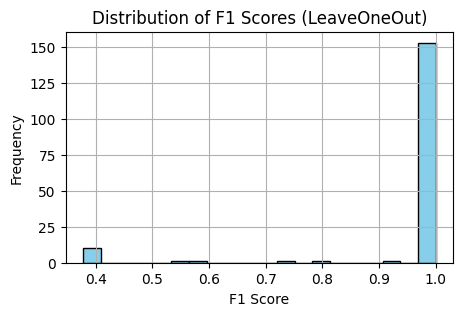

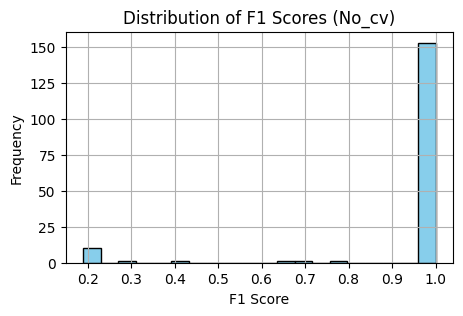

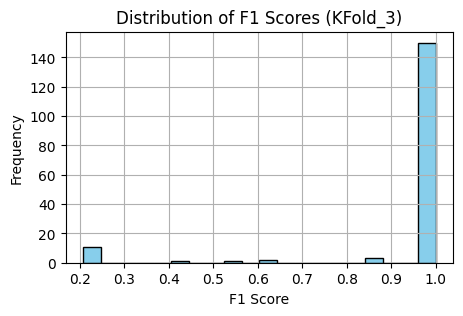

In [12]:
plot_f1_score_distribution('LeaveOneOut')
plot_f1_score_distribution('No_cv')
plot_f1_score_distribution('KFold_3')


In [13]:
def load_gridsearch_results(filename):
    with open(filename, 'rb') as file:
        grid_search_results = pickle.load(file)
    
    return grid_search_results

In [14]:
def find_best_model_params_for_cv_method(cv_method, print_all=False):
    results = []
    if cv_method == 'LeaveOneOut':
        for i in [1,2,3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))
    
    best_by_combined_time={}

    for n, result in enumerate(results):        
        perfect_f1_count, ranked_by_score_time, ranked_by_fit_time, ranked_by_combined_time = create_ranked_lists(result)
        if ranked_by_combined_time is None:
            continue
        
        if print_all:
            # Print Ranked by Mean Score Time
            print("Ranked by Mean Score Time:")
            print(ranked_by_score_time[['mean_score_time', 'mean_test_f1', 'params']])

            # Print Ranked by Mean Fit Time
            print("\nRanked by Mean Fit Time:")
            print(ranked_by_fit_time[['mean_fit_time', 'mean_test_f1', 'params']])

            # Print Ranked by Combined Time (mean_score_time + mean_fit_time)
            print("\nRanked by Combined Time:")
            print(ranked_by_combined_time[['combined_time', 'mean_test_f1', 'params']])
        if cv_method == 'LeaveOneOut':
            best_by_combined_time[n+1] = ranked_by_combined_time.iloc[0]

    if cv_method == 'LeaveOneOut':
        min_combined_time = 1000
        best_index = -1
        best_params = None
        for n in best_by_combined_time.keys():
            if best_by_combined_time[n]['combined_time'] < min_combined_time:
                min_combined_time = best_by_combined_time[n]['combined_time']
                best_index = n
                best_params = best_by_combined_time[n]
        # print("BEST PARAMETERS IN TERMS OF COMBINED TIME:", best_params)
        return best_params
    else:
        # print("BEST PARAMETERS IN TERMS OF COMBINED TIME:", ranked_by_combined_time.iloc[0])
        return ranked_by_combined_time.iloc[0]


In [15]:
genes = GeneAnalysis()

Data has been loaded.
Splitting train-test 80-20.


In [16]:
from sklearn.metrics import  make_scorer, accuracy_score, f1_score, confusion_matrix, roc_auc_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
def plot_confusion_matrix(cm, model_name=None, save=False, show=False):
    if save and model_name is None:
        print("Please specify which model you are plotting with model_name=")
        return
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(genes.y_test))

    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax)
    
    plt.title(f'Confusion Matrix for Best Model with {model_name} CV')
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save:
        plt.savefig(self.save_path+'/'+model_name+'_confusion_matrix.png', format='png', dpi=300)
        print(f"Plot saved as {self.save_path}'/'{model_name}'_cluster_confusion_matrix.png")
    if show:
        plt.show(block=True)
    plt.close(fig)

In [18]:

def evaluate_model_on_test_set(params):
    pipeline, _ = genes.get_pipeline_and_param_grid()
    pipeline.set_params(**best.params)
    model = pipeline.fit(genes.X_train, genes.y_train)

    y_pred = model.predict(genes.X_test)
    y_pred_proba = model.predict_proba(genes.X_test)

    acc = accuracy_score(genes.y_test, y_pred)
    f1 = f1_score(genes.y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(genes.y_test, y_pred_proba, multi_class='ovo', average='weighted', labels=np.unique(genes.y_test))
    cm = confusion_matrix(genes.y_test, y_pred, labels=np.unique(genes.y_test))

    return acc, f1, roc_auc, cm

Number of models with a perfect F1 score: 131
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform', 'feature_selection': 'passthrough'}


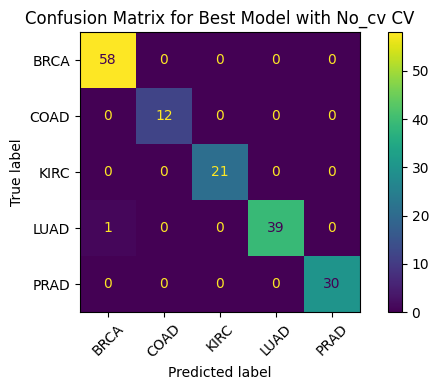

0.9937888198757764 0.9937760521139718 1.0


In [19]:
best = find_best_model_params_for_cv_method('No_cv', print_all=False)
print(best.params)
pipeline, _ = genes.get_pipeline_and_param_grid()
pipeline.set_params(**best.params)
model = pipeline.fit(genes.X_train, genes.y_train)
acc, f1, roc, cm = evaluate_model_on_test_set(model)
plot_confusion_matrix(cm=cm, model_name='No_cv', show=True)
print(acc, f1, roc)

In [20]:
def plot_cv_method_metrics_comparison(cv_methods):
    # Initialize lists to store metrics for each cv_method
    metrics = {'Accuracy': [], 'F1 Score': [], 'ROC AUC': []}
    cv_labels = []

    # Iterate over each cv_method to get the best model params and evaluate
    for cv_method in cv_methods:
        # Find the best model params for the cv_method
        best_params = find_best_model_params_for_cv_method(cv_method)
        
        # Evaluate the model on the test set
        acc, f1, roc_auc, cm = evaluate_model_on_test_set(best_params)

        # Store the results in the metrics dictionary
        metrics['Accuracy'].append(acc)
        metrics['F1 Score'].append(f1)
        metrics['ROC AUC'].append(roc_auc)
        cv_labels.append(cv_method)

    # Create the bar plot
    x = np.arange(len(cv_methods))  # The label locations
    width = 0.25  # The width of the bars

    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot each metric as a separate group of bars
    ax.bar(x - width, metrics['Accuracy'], width, label='Accuracy', color='skyblue')
    ax.bar(x, metrics['F1 Score'], width, label='F1 Score', color='lightgreen')
    ax.bar(x + width, metrics['ROC AUC'], width, label='ROC AUC', color='salmon')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Cross-Validation Method')
    ax.set_ylabel('Scores')
    ax.set_title('Accuracy, F1 Score, and ROC AUC for Best Models by CV Method')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_labels)
    ax.legend(loc='lower right')

    # Show the plot
    plt.tight_layout()
    plt.show()

Number of models with a perfect F1 score: 3
###### No models have F1 score of 1 ######
Number of models with a perfect F1 score: 6
Number of models with a perfect F1 score: 131
Number of models with a perfect F1 score: 10


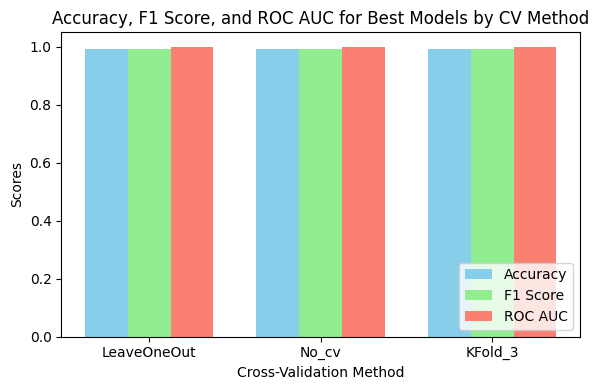

In [21]:
cv_methods = ['LeaveOneOut', 'No_cv', 'KFold_3']
plot_cv_method_metrics_comparison(cv_methods)

In [22]:
def plot_best_model_across_cv_methods(cv_method, cv_methods):
    # Find the best model params for the input cv_method
    best_params = find_best_model_params_for_cv_method(cv_method)

    # Initialize lists to store metrics for each cv_method
    metrics = {'Accuracy': [], 'F1 Score': [], 'ROC AUC': []}
    cv_labels = []

    # Evaluate the model for the input cv_method
    best_acc, best_f1, best_roc_auc, _ = evaluate_model_on_test_set(best_params)
    
    # Store the metrics for the input cv_method
    metrics['Accuracy'].append(best_acc)
    metrics['F1 Score'].append(best_f1)
    metrics['ROC AUC'].append(best_roc_auc)
    cv_labels.append(cv_method)

    # Retrieve the same model's scores from the grid search results of other cv_methods
    for method in cv_methods:
        if method == cv_method:
            continue
        
        # Load grid search results for the other cv_method
        grid_search_results = load_gridsearch_results(f'Genes_plots/{method}_grid_search.pkl')
        
        # Find the corresponding scores for the best model params
        cv_results = grid_search_results.cv_results_
        for i, params in enumerate(cv_results['params']):
            if params == best_params.params:  # Compare model params
                acc = cv_results['mean_test_accuracy'][i]
                f1 = cv_results['mean_test_f1'][i]
                roc_auc = cv_results['mean_test_roc_auc'][i]
                
                # Store the metrics for this cv_method
                metrics['Accuracy'].append(acc)
                metrics['F1 Score'].append(f1)
                metrics['ROC AUC'].append(roc_auc)
                cv_labels.append(method)
                break

    # Create the bar plot
    x = np.arange(len(cv_labels))  # The label locations
    width = 0.25  # The width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each metric as a separate group of bars
    ax.bar(x - width, metrics['Accuracy'], width, label='Accuracy', color='skyblue')
    ax.bar(x, metrics['F1 Score'], width, label='F1 Score', color='lightgreen')
    ax.bar(x + width, metrics['ROC AUC'], width, label='ROC AUC', color='salmon')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Cross-Validation Method')
    ax.set_ylabel('Scores')
    ax.set_title(f'Best Model Scores Across CV Methods (Starting with {cv_method})')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_labels)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [23]:
def load_gridsearch_results_for_cv_method(cv_method):
    """Helper function to load grid search results based on the cv_method."""
    results = []
    
    if cv_method == 'LeaveOneOut':
        for i in [1, 2, 3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/KFold_3_grid_search.pkl'))
    
    return results

In [24]:
def plot_all_best_models_across_cv_methods(cv_methods):
    # Initialize a dictionary to store metrics for each cv_method
    results_per_method = {}
    cv_labels = []

    # Loop through each cv_method to find the best model and compare across other methods
    for cv_method in cv_methods:
        results_per_method[cv_method] = {}
        # Find the best model params for the current cv_method
        best_params = find_best_model_params_for_cv_method(cv_method)
        results_per_method[cv_method][cv_method] = best_params.mean_test_f1

        # Retrieve the metrics for the same model across all cv_methods
        for method in cv_methods:
            if method == cv_method:
                continue

            # Load grid search results using the custom loading function
            grid_search_results_list = load_gridsearch_results_for_cv_method(method)
            
            for grid_search_results in grid_search_results_list:
                cv_results = grid_search_results.cv_results_

                # Find the corresponding scores for the best model params
                for i, params in enumerate(cv_results['params']):
                    # print(params)
                    found_model = []
                    for best_param in best_params.params:
                        curr_param_found = False
                        for param in params.values():
                            if type(best_param) == (type(param)):
                                curr_param_found = True
                                continue
                        found_model.append(curr_param_found)

                    if False not in found_model:  # Compare model params
                        results_per_method[cv_method][method] = cv_results['mean_test_f1'][i]
                        found_model = True
                        break
                if found_model:
                    break

            # If the model wasn't found in this cv_method, append None or default value
            if not found_model:
                print("model not found")
                results_per_method[cv_method][method] = None

    print(results_per_method)

    # Create the bar plot
    x = np.arange(len(cv_methods))  # The label locations
    width = 0.25  # The width of the bars
    fig, ax = plt.subplots(figsize=(6, 4))

    colours = ['skyblue', 'lightgreen', 'salmon']
    position = [-1, 0, 1]
    # Plot each metric as a separate group of bars
    for cv_method in cv_methods:
        for i, method in enumerate(cv_methods):
            ax.bar(x + (position[i]*width), results_per_method[cv_method][method], width, label=method, color=colours[i])

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Cross-Validation Method')
    ax.set_ylabel('Scores')
    ax.set_title('Comparing the Best Model per CV Method to Equivalent Model in other CV Methods')
    ax.set_xticks(x)
    ax.set_xticklabels(cv_methods)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower right')
    # ax.legend(loc='lower right')

    # Show the plot
    plt.tight_layout()
    plt.show()

Number of models with a perfect F1 score: 3
###### No models have F1 score of 1 ######
Number of models with a perfect F1 score: 6
Number of models with a perfect F1 score: 131
Number of models with a perfect F1 score: 10
{'LeaveOneOut': {'LeaveOneOut': 1.0, 'No_cv': 1.0, 'KFold_3': 0.9968847352024922}, 'No_cv': {'No_cv': 1.0, 'LeaveOneOut': 0.9984375, 'KFold_3': 0.9968847352024922}, 'KFold_3': {'KFold_3': 1.0, 'LeaveOneOut': 0.9984375, 'No_cv': 1.0}}


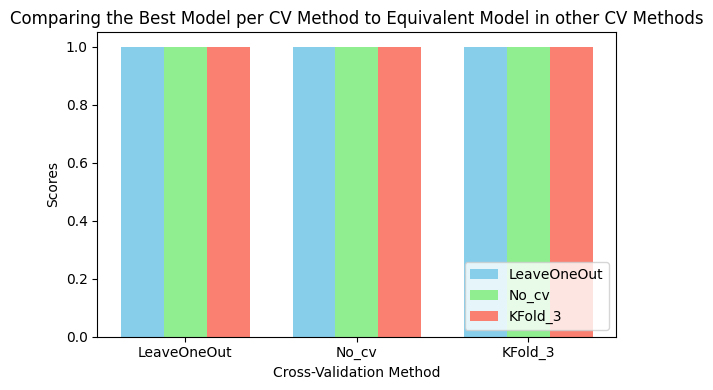

In [25]:
cv_methods = ['LeaveOneOut', 'No_cv', 'KFold_3']
plot_all_best_models_across_cv_methods(cv_methods)

In [26]:
def find_best_reduced_dataset(cv_method):
    results = []
    if cv_method == 'LeaveOneOut':
        for i in [1,2,3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))

    cv_results = results[0].cv_results_
    
    df = pd.DataFrame({
        'mean_fit_time': cv_results['mean_fit_time'],
        'mean_score_time': cv_results['mean_score_time'],
        'mean_test_f1': cv_results['mean_test_f1'],
        'params': cv_results['params']  
    })

    results = []

    for index, row in df.iterrows():
        params = row['params']
        
        # Check if there is a feature extraction method that is NOT 'passthrough'
        if params.get('feature_selection', 'passthrough') != 'passthrough':
            # Extract relevant data
            feature_extraction_method = params['feature_selection']
            mean_fit_time = row['mean_fit_time']
            mean_score_time = row['mean_score_time']

            # Extract all hyperparameters related to the feature_selection step
            feature_selection_params = {key: val for key, val in params.items() if key.startswith('feature_selection__')}

            # Calculate combined score (fit + score time) and subtract the F1 score
            # Here we subtract F1 score to maximize it, as lower combined value is better
            combined_score = mean_fit_time + mean_score_time

            # Append the feature extraction method and combined score to the results list
            results.append({
                'feature_extraction': feature_extraction_method,
                'hyperparameters': feature_selection_params,
                'combined_score': combined_score
            })
    
    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results)

    # Find the feature extraction method with the lowest combined score
    best_method = results_df.loc[results_df['combined_score'].idxmin()]

    return best_method

In [33]:
cv_methods = ['LeaveOneOut', 'No_cv', 'KFold_3']
for method in cv_methods:
    print(find_best_reduced_dataset(method))

feature_extraction    SelectKBest(score_func=<function mutual_info_c...
hyperparameters                          {'feature_selection__k': 1000}
combined_score                                                93.081788
Name: 54, dtype: object
feature_extraction                                     PCA()
hyperparameters       {'feature_selection__n_components': 3}
combined_score                                      0.420882
Name: 114, dtype: object
feature_extraction                                     PCA()
hyperparameters       {'feature_selection__n_components': 3}
combined_score                                      0.569564
Name: 111, dtype: object


In [ ]:
if use_normalized:
    data_numeric = self.data_normalized.apply(pd.to_numeric, errors='coerce').dropna(axis=0)
else:
    data_numeric = self.data.apply(pd.to_numeric, errors='coerce').dropna(axis=0)

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_numeric)
explained_variance = pca.explained_variance_ratio_

if plot:
    self.plot_PCA(use_normalized, data_pca, explained_variance, save)

return data_pca, explained_variance

In [46]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

In [54]:
def apply_feature_reduction(params, plot):
    if type(params['feature_extraction']) == SelectKBest():
        mutual_info = mutual_info_classif(genes.data, genes.labels.values.ravel())
        feature_scores = pd.Series(genes.X_train, index=genes.data.columns)
        top_features = feature_scores.sort_values(ascending=False).head(params['hyperparameters']['feature_selection__k']).index
        return top_features
    elif type(params['feature_extraction']) == PCA():
        data_numeric = genes.X_train.apply(pd.to_numeric, errors='coerce').dropna(axis=0)
        pca = PCA(**params.params['hyperparameters'])
        data_pca = pca.fit_transform(data_numeric)
        explained_variance = pca.explained_variance_ratio_

        if plot:
            genes.plot_PCA(False, data_pca, explained_variance, False)
    


In [52]:
apply_feature_reduction(find_best_reduced_dataset('LeaveOneOut'), plot=False)

1000

In [28]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
 

In [29]:
type(ds['feature_extraction']) == SelectKBest

NameError: name 'ds' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_reduction_vs_accuracy_all_methods(cv_methods):
    results = {}
    
    # Iterate through each cross-validation method
    for cv_method in cv_methods:
        cv_results_list = []

        # Handle the LOO case with multiple runs
        if cv_method == 'LeaveOneOut':
            for i in [1, 2, 3]:
                cv_results_list.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
        elif cv_method == 'No_cv':
            cv_results_list.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
        elif cv_method == 'KFold_3':
            cv_results_list.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))

        # Combine results for LOO by averaging across the different runs
        pca_results = {}
        mutual_info_results = {}

        for result in cv_results_list:
            cv_results = result.cv_results_

            df = pd.DataFrame({
                'mean_fit_time': cv_results['mean_fit_time'],
                'mean_score_time': cv_results['mean_score_time'],
                'mean_test_f1': cv_results['mean_test_f1'],
                'params': cv_results['params']  
            })

            for index, row in df.iterrows():
                params = row['params']
                mean_test_f1 = row['mean_test_f1']

                # Extract relevant feature extraction methods and their hyperparameters
                feature_extraction_method = params.get('feature_selection', 'passthrough')

                if type(feature_extraction_method) == PCA:
                    n_components = params.get('feature_selection__n_components', None)
                    if n_components is not None:
                        if n_components not in pca_results:
                            pca_results[n_components] = []
                        pca_results[n_components].append(mean_test_f1)

                if type(feature_extraction_method) == SelectKBest:
                    k = params.get('feature_selection__k', None)
                    if k is not None:
                        if k not in mutual_info_results:
                            mutual_info_results[k] = []
                        mutual_info_results[k].append(mean_test_f1)

        # Calculate average accuracies across LOO runs (or other methods if applicable)
        pca_avg_accuracy = {k: np.mean(v) for k, v in pca_results.items()}
        mutual_info_avg_accuracy = {k: np.mean(v) for k, v in mutual_info_results.items()}

        # Store the results in a dictionary keyed by the cv_method
        results[cv_method] = {
            'pca': pca_avg_accuracy,
            'mutual_info': mutual_info_avg_accuracy
        }

    # Plotting all CV methods on the same plot
    plt.figure(figsize=(12, 5))

    # Plot PCA results
    plt.subplot(1, 2, 1)
    for cv_method, result in results.items():
        pca_keys = list(result['pca'].keys())
        pca_values = list(result['pca'].values())
        plt.plot(pca_keys, pca_values, marker='o', label=cv_method)
    
    plt.title('PCA: Number of Components vs Accuracy')
    plt.xlabel('Number of Components')
    plt.ylabel('Average F1 Score')
    plt.legend(title="CV Method")
    
    # Set y-limits and ticks based on the min and max values across all methods
    all_pca_values = [val for result in results.values() for val in result['pca'].values()]
    min_value = min(all_pca_values) * .99
    max_value = max(all_pca_values) * 1.01
    plt.ylim(bottom=min_value, top=max_value)
    plt.yticks(np.arange(min_value, max_value, step=(max_value - min_value) /5))
    plt.grid()

    # Plot Mutual Information results
    plt.subplot(1, 2, 2)
    for cv_method, result in results.items():
        mutual_info_keys = list(result['mutual_info'].keys())
        mutual_info_values = list(result['mutual_info'].values())
        plt.plot(mutual_info_keys, mutual_info_values, marker='o', label=cv_method)

    plt.title('Mutual Information: Top K Features vs Accuracy')
    plt.xlabel('Top K Features')
    plt.ylabel('Average F1 Score')
    plt.legend(title="CV Method")
    
    # Set y-limits and ticks based on the min and max values across all methods
    all_mutual_info_values = [val for result in results.values() for val in result['mutual_info'].values()]
    min_value = min(all_mutual_info_values) *.99
    max_value = max(all_mutual_info_values) * 1.01
    plt.ylim(bottom=min_value, top=max_value)
    plt.yticks(np.arange(min_value, max_value, step=(max_value - min_value) / 5))
    plt.grid()

    plt.tight_layout()
    plt.show()


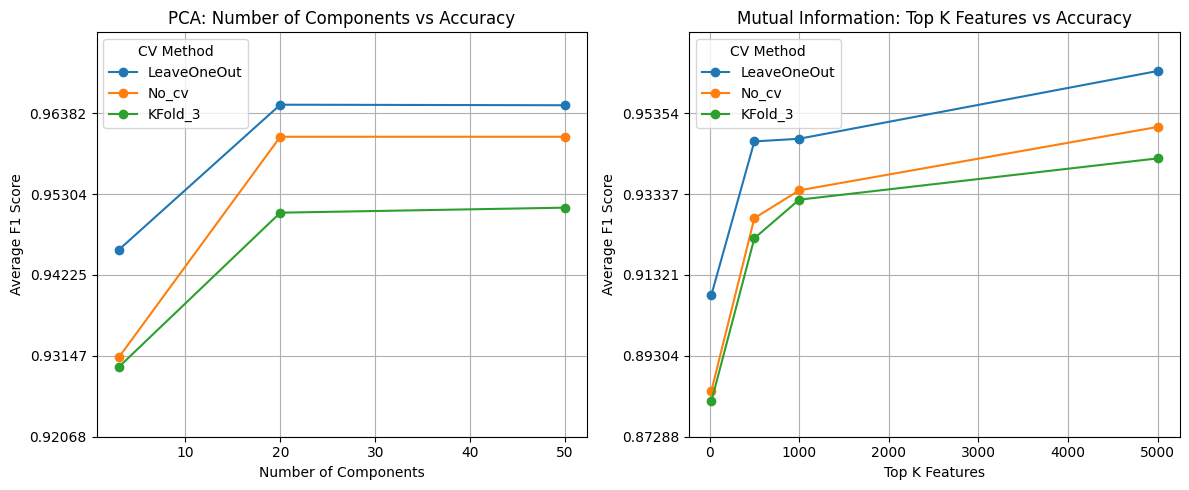

In [ ]:
cv_methods = ['LeaveOneOut', 'No_cv', 'KFold_3']
plot_feature_reduction_vs_accuracy_all_methods(cv_methods)